In [1]:
from pyswarm import pso

from os import path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import os

import numpy as np
import pandas as pd
import time
import random
from math import sqrt 
import random
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Cropping1D, Cropping2D, TimeDistributed, Dense, Dropout, LSTM, Conv1D, Flatten, Activation, MaxPooling1D
from json import loads
from scipy.ndimage.filters import uniform_filter1d
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow
import matplotlib.pyplot as plt 
import re
from util import *
from tqdm import tqdm

<ipython-input-1-21140ef926ab>:21: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [2]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def hasLSTM(model):
	firstlayer=model.layers[0].name[:4]
	if(firstlayer=='lstm'):
		answer=True
	else:
		answer=False
	return answer

def hasCONV1D(model):
	firstlayer=model.layers[0].name[:6]
	if(firstlayer=='conv1d'):
		answer=True
	else:
		answer=False
	return answer

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def metrics(model, X_test, y_test_3d, scaler, cpu_user_col, cpu_system_col, cpu_idle_col, ram_col):#, upload_col, label_col):
  
  global lookahead

  
  results_dict = {'cpu_user_time_diff_observations':[], 'cpu_user_time_diff_predicted_observations':[], 'cpu_user_time_diff_mae':[], 'cpu_user_time_diff_rmse':[],
   'cpu_system_time_diff_observations':[], 'cpu_system_time_diff_predicted_observations':[],  'cpu_system_time_diff_mae':[], 'cpu_system_time_diff_rmse':[],
    'cpu_idle_time_diff_observations':[], 'cpu_idle_time_diff_predicted_observations':[],  'cpu_idle_time_diff_mae':[], 'cpu_idle_time_diff_rmse':[],
     'memory_observations':[], 'memory_predicted_observations':[], 'memory_mae':[], 'memory_rmse':[]}
     #,'net_sent_diff_observations':[], 'net_sent_diff_predicted_observations':[], 'net_sent_diff_mae':[], 'net_sent_diff_rmse':[]}
     #,'label_observations':[], 'label_predicted_observations':[], 'label_mae':[], 'label_rmse':[]}
  
  prediction_3d = model.predict(X_test)
  
  iter_list = [('cpu_user_time_diff',cpu_user_col), ('cpu_system_time_diff',cpu_system_col),('cpu_idle_time_diff',cpu_idle_col),('memory',ram_col)]#,('net_sent_diff',upload_col),('label',label_col)]

  for feature_name, feature_col in iter_list:
    print(feature_name)

    if model_type == 'with conv--':
      y_test_3d = y_test_3d.reshape(y_test_3d.shape[0],lookahead,X_test.shape[2])
      prediction_3d = prediction_3d.reshape(prediction_3d.shape[0],lookahead,X_test.shape[2])
    
    for row in tqdm(range(len(y_test_3d))):

      y_test=scaler.inverse_transform(y_test_3d[row,:,:])
      prediction=scaler.inverse_transform(prediction_3d[row,:,:])

      results_dict[feature_name+'_observations'].append(y_test[:,feature_col].tolist())
      prds = [0 if i < 0 else i for i in prediction[:,feature_col].tolist()]

      results_dict[feature_name+'_predicted_observations'].append(prds)
      results_dict[feature_name+'_rmse'].append(sqrt(mean_squared_error(y_test[:,feature_col], prds)))
      results_dict[feature_name+'_mae'].append(mean_absolute_error(y_test[:,feature_col], prds)) 

  


      
  
  return results_dict


def inference(model, X, pred_loc, pred_shift):
  #i=random.randrange(len(X))	
  startS=time.time()	
  prediction=model.predict(X[[pred_loc]])	
  timeS=time.time()-startS
  #i=random.randrange(len(X)-pred_shift)
  input = X[pred_loc:pred_loc+pred_shift+1]
  startB=time.time()
  batch_prediction=model.predict(input)
  timeB=time.time()-startB
  return timeS, timeB

def data_preparation(datasetfile, drop_list):
  dataframe = pd.read_csv(datasetfile, engine='python')
  
  if 'time_stamp' in dataframe.columns:
    dataframe = dataframe.drop(drop_list, axis=1)  
  
  cpu_user_column = dataframe.columns.get_loc("cpu_user_time_diff")
  cpu_system_column = dataframe.columns.get_loc("cpu_system_time_diff")
  cpu_idle_column = dataframe.columns.get_loc("cpu_idle_time_diff")
  ram_column = dataframe.columns.get_loc("memory")
  #upload_column = dataframe.columns.get_loc("net_sent_diff")
  #label_column = dataframe.columns.get_loc("label")

  dataframe = dataframe.fillna(0)
  dataset = dataframe.values
  dataset = np.nan_to_num(dataset)
  dataset = dataset.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = MaxAbsScaler()
  scaler.fit(dataset)
  dataset = scaler.transform(dataset)
  return dataset, scaler, cpu_user_column, cpu_system_column, cpu_idle_column, ram_column#, upload_column, label_column

def remove_dupes(i, o):
	for j in range(len(i)):
		for k in range(len(i)):
			if (i[j]==i[k] and j!=k):
				if (o[j]>o[k]):
					i.pop(j)
					o.pop(j)
					return remove_dupes(i, o)
				else:
					i.pop(k)
					o.pop(k)
					return remove_dupes(i, o)
	return i, o

def train_test(model, dataset, lookback, lookahead, split, model_type):
  if hasLSTM(model) or hasCONV1D(model):
    dataset,datasetY=split_sequences(dataset,lookback,lookahead)
    if model_type == 'with lstm':
      datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[1],datasetY.shape[2]) 
    elif model_type == 'with conv':
      datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[2]*datasetY.shape[1]) 
  else: # not used 
    dataset,datasetY=split_sequences(dataset,1,1)  
    dataset=dataset.reshape(dataset.shape[0],dataset.shape[2])
    datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[2])  
  train_size = int(len(dataset) * split)
  #test_size = len(dataset) - train_size
  trainX, testX = dataset[0:train_size,:], dataset[train_size:,:]
  trainY, testY = datasetY[0:train_size,:], datasetY[train_size:,:] 
  return trainX, testX, trainY, testY

def getOptimizer(x4, optimizer):
  learning_rate = x4
  if optimizer =='RMSprop':
    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer =='Adam':
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer =='SGD':
    optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer =='Adagrad':
    optimizer = tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif optimizer =='Adadelta':
    optimizer = tensorflow.keras.optimizers.Adadelta(learning_rate=learning_rate)
  elif optimizer =='Adamax':
    optimizer = tensorflow.keras.optimizers.Adamax(learning_rate=learning_rate)
  else:
    optimizer = tensorflow.keras.optimizers.Nadam(learning_rate=learning_rate)

  return optimizer

def build_model(activationFunction, optimizer, pred_type):
  global dataset, defineModel, lookback, lookahead, neurons, numOfLayers, dropout, noOfLSTM_CONV, pool_size
  
  """
  if defineModel == False:
    defineModel = True
    models = ['with lstm', 'with conv']
    typeOfModel = random.choice(models)
  """
  typeOfModel = random.choice(['with lstm', 'with conv'])
  model = Sequential()
  neurons = int(round(x0))
  numOfLayers = int(round(x1))
  dropout = truncate(x3,1)
  lookback = int(round(x2))
  optimization = getOptimizer(x4, optimizer)
  noOfLSTM_CONV = int(round(x7))
  pool_size = int(round(x8))
  
  
 
  if typeOfModel == 'with lstm':
    for i in range(1,noOfLSTM_CONV+1):
        if i == 1:
            model.add(LSTM(neurons, input_shape=(lookback, dataset.shape[1]), activation=activationFunction, recurrent_activation='sigmoid', implementation=2, return_sequences=True))
        else:
            model.add(LSTM(neurons,activation=activationFunction, recurrent_activation='sigmoid', implementation=2, return_sequences=True)) 
  
    units = neurons
    for i in range(1,numOfLayers+1):
        units = int(round(units/2))
        if units > 0:    
          model.add(TimeDistributed(Dense(units, activation=activationFunction)))
          model.add(TimeDistributed(Dropout(dropout)))

    model.add(TimeDistributed(Dense(dataset.shape[1])))

    model.add(Cropping1D(cropping=(lookback-lookahead,0)))


  elif typeOfModel == 'with conv':
    for i in range(1,noOfLSTM_CONV+1):
        if i == 1:
            model.add(Conv1D(filters=neurons, kernel_size=2, padding='same', activation=activationFunction, input_shape=(lookback,dataset.shape[-1])))
            model.add(MaxPooling1D(pool_size=pool_size, padding='same')) 
        else:
            model.add(Conv1D(filters=neurons, kernel_size=2, padding='same', activation=activationFunction))
            model.add(MaxPooling1D(pool_size=pool_size, padding='same')) 
    model.add(Flatten())

    units = neurons
    for i in range(1,numOfLayers+1):
        units = int(round(units/2))
        if units > 0:    
          model.add(Dense(units, activation=activationFunction))
          model.add(Dropout(dropout))

  if pred_type == 'regression':

    model.add(Dense(lookahead*dataset.shape[1]))

    model.compile(loss='mse',
                optimizer=optimization,
                metrics=['mae', 'mse'])

  elif pred_type == 'classification':
    model.add(Dense(lookahead*dataset.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimization,
                metrics=['accuracy'])

  return model, typeOfModel

  

def plot_pred_obs(pred_data1, pred_data2, obs_data, title, unit, type, rpi, method1, method2, filter, save = False):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(obs_data,label = 'Observed', color = '#4876FF', linestyle = '-',alpha = 1)
  ax.plot(pred_data1,label = f'{method1} - Predicted', color = '#FF4040',linestyle = '-',alpha = 0.7)
  ax.plot(pred_data2,label = f'{method2} - Predicted', color = '#43CD80',linestyle = '-',alpha = 0.7)
  
  print(title)
  # ax.set_title(method +' - '+ title)#, color = 'white')
  ax.grid(alpha=0.5)
  ax.legend(loc='best')
  #ax.tick_params(axis='x', colors='white')
  #ax.tick_params(axis='y', colors='white')
  #ax.yaxis.label.set_color('white')
  #ax.xaxis.label.set_color('white')
  ax.set_xlabel('Datapoint')#, color = 'white')
  ax.set_ylabel(unit)#, color = 'white')
  ax.set_ylim(bottom=0)
  if save == True:
    if filter == 1:
      f_path = 'Non Filtered'
    else:
      f_path = 'Filtered'
    plt_name = title.replace(" ", "_")
    try:
      os.makedirs(r"figures/{}/{}/{}/{} Step/{}".format(type,rpi,method,lookahead,f_path))
    except:
      pass
    save_path = r"figures/{}/{}/{}/{} Step/{}/{}_{}step_{}ma.png".format(type,rpi,method,lookahead,f_path,plt_name,lookahead,filter) 
    plt.savefig(save_path)
  else:
    plt.show()

HBPSHPO figures for RPi4B8GB_1800_pattern for 1 step
HSMM figures for RPi4B8GB_1800_pattern for 1 step
CPU User Time


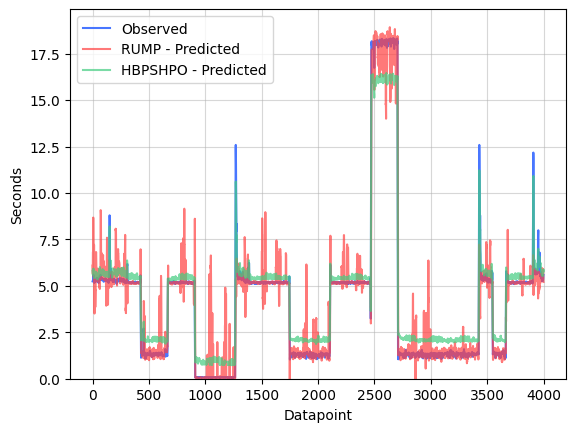

CPU System Time


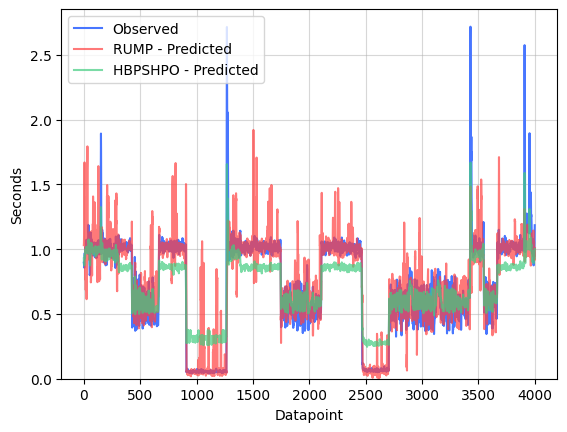

CPU Idle Time


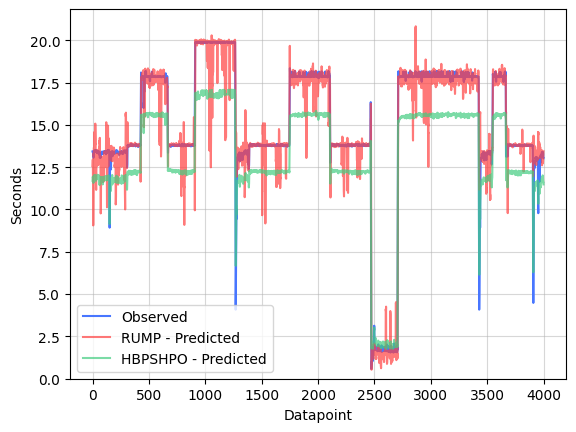

RAM


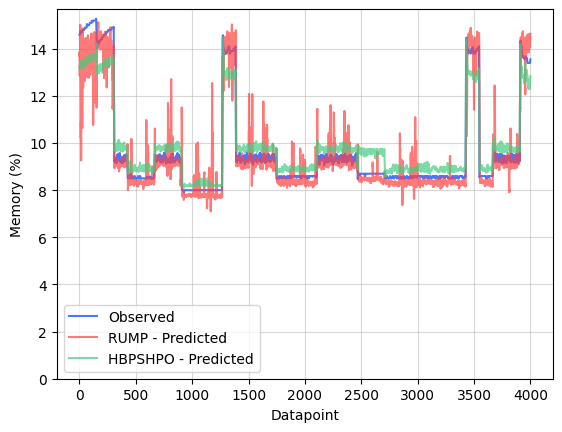

In [3]:
"""Get prediction figures"""

rpi_name = 'RPi4B8GB_1800' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
data_seq = 'pattern' # random, pattern
data_num = '' # _2, _3, _4
methods = ['HBPSHPO', 'HSMM']
methods_dict = {'HBPSHPO':{},'HSMM':{}}
lookahead_list = [1]#,2,5,10,15,30,60]
filter = 4 # 1, 25, 50, 100

for method in methods:
  for lookahead in lookahead_list:
    print(f"{method} figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")
    model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'
    if method == 'HSMM':
      obs_dict = pd.read_csv(f"Results/{rpi_name.split('_')[0]}/HSMM_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
    elif method == 'HBPSHPO':
      obs_dict = pd.read_csv(f"Results/{rpi_name.split('_')[0]}/HBPSHPO_Results_{model_name}.csv")

    methods_dict[method]['user_cpu_obs'], methods_dict[method]['user_cpu_pred_obs'] = [], []
    methods_dict[method]['system_cpu_obs'], methods_dict[method]['system_cpu_pred_obs'] = [], []
    methods_dict[method]['idle_cpu_obs'], methods_dict[method]['idle_cpu_pred_obs'] = [], []
    methods_dict[method]['ram_obs'], methods_dict[method]['ram_pred_obs'] = [], []
    #label_obs, label_pred_obs = [], []
    #net_sent_obs, net_sent_pred_obs = [], []
    

    for i in range(0,len(obs_dict),lookahead):
      
      methods_dict[method]['user_cpu_obs'].extend(loads(obs_dict['cpu_user_time_diff_observations'][i]))
      methods_dict[method]['user_cpu_pred_obs'].extend(loads(obs_dict['cpu_user_time_diff_predicted_observations'][i]))
      methods_dict[method]['system_cpu_obs'].extend(loads(obs_dict['cpu_system_time_diff_observations'][i]))
      methods_dict[method]['system_cpu_pred_obs'].extend(loads(obs_dict['cpu_system_time_diff_predicted_observations'][i]))
      methods_dict[method]['idle_cpu_obs'].extend(loads(obs_dict['cpu_idle_time_diff_observations'][i]))
      methods_dict[method]['idle_cpu_pred_obs'].extend(loads(obs_dict['cpu_idle_time_diff_predicted_observations'][i]))
      #net_sent_obs.extend(loads(obs_dict['net_sent_diff_observations'][i]))
      #net_sent_pred_obs.extend(loads(obs_dict['net_sent_diff_predicted_observations'][i]))
      methods_dict[method]['ram_obs'].extend(loads(obs_dict['memory_observations'][i]))
      methods_dict[method]['ram_pred_obs'].extend(loads(obs_dict['memory_predicted_observations'][i]))
      #label_obs.extend(loads(obs_dict['label_observations'][i]))
      #label_pred_obs.extend(loads(obs_dict['label_predicted_observations'][i]))

shift = -300

plot_pred_obs(uniform_filter1d(methods_dict['HSMM']['user_cpu_pred_obs'][4000:8000], size=filter),uniform_filter1d(methods_dict['HBPSHPO']['user_cpu_pred_obs'][4000-shift:8000-shift], size=filter),uniform_filter1d(methods_dict['HSMM']['user_cpu_obs'][4000:8000], size=filter) , 'CPU User Time', 'Seconds', data_seq + data_num, rpi_name.split('_')[0], 'RUMP','HBPSHPO', filter)#, True)
plot_pred_obs(uniform_filter1d(methods_dict['HSMM']['system_cpu_pred_obs'][4000:8000], size=filter), uniform_filter1d(methods_dict['HBPSHPO']['system_cpu_pred_obs'][4000-shift:8000-shift], size=filter), uniform_filter1d(methods_dict['HSMM']['system_cpu_obs'][4000:8000], size=filter) , 'CPU System Time', 'Seconds', data_seq + data_num, rpi_name.split('_')[0], 'RUMP','HBPSHPO',filter)#, True)
plot_pred_obs(uniform_filter1d(methods_dict['HSMM']['idle_cpu_pred_obs'][4000:8000], size=filter), uniform_filter1d(methods_dict['HBPSHPO']['idle_cpu_pred_obs'][4000-shift:8000-shift], size=filter), uniform_filter1d(methods_dict['HSMM']['idle_cpu_obs'][4000:8000], size=filter), 'CPU Idle Time', 'Seconds', data_seq + data_num, rpi_name.split('_')[0], 'RUMP','HBPSHPO',filter)#, True)
plot_pred_obs(uniform_filter1d(methods_dict['HSMM']['ram_pred_obs'][4000:8000], size=filter), uniform_filter1d(methods_dict['HBPSHPO']['ram_pred_obs'][4000-shift:8000-shift], size=filter), uniform_filter1d(methods_dict['HSMM']['ram_obs'][4000:8000], size=filter), 'RAM', 'Memory (%)', data_seq + data_num, rpi_name.split('_')[0], 'RUMP','HBPSHPO',filter)#, True)
#plot_pred_obs(uniform_filter1d(net_sent_pred_obs, size=filter) , uniform_filter1d(net_sent_obs, size=filter), 'Network Upload', 'Bytes', method, filter, True)

In [4]:
def mk_groups(data):
  try:
      newdata = data.items()
  except:
      return

  thisgroup = []
  groups = []
  for key, value in newdata:
      newgroups = mk_groups(value)
      if newgroups is None:
          thisgroup.append((key, value))
      else:
          thisgroup.append((key, len(newgroups[-1])))
          if groups:
              groups = [g + n for n, g in zip(newgroups, groups)]
          else:
              groups = newgroups
  return [thisgroup] + groups

def add_line(ax, xpos, ypos, plus, minus):
  line = plt.Line2D([xpos, xpos], [ypos + plus, ypos - minus],
                    transform=ax.transAxes, color='black')
  line.set_clip_on(False)
  ax.add_line(line)

def label_group_bar(ax, mae_data, rmse_data):
  
  mae_groups, rmse_groups = mk_groups(mae_data), mk_groups(rmse_data)
  mae_xy, rmse_xy = mae_groups.pop(), rmse_groups.pop()
  mae_x, mae_y = zip(*mae_xy)
  rmse_x, rmse_y = zip(*rmse_xy)
  mae_ly, rmse_ly = len(mae_y), len(rmse_y)
  mae_xticks, rmse_xticks = np.arange(1, mae_ly + 1), np.arange(1, mae_ly + 1)

  color_pair1 = ['#aaffc3', '#8B3A3A']  # color pair 1:  Mint, Apricot: #ffd8b1, Blueviolet: #8A2BE2
  color_pair2 = ['#458B74','#FF6A6A']  # color pair 2: Teal, Beige: #fffac8, Pink: #fabed4


  # define list of dark colors
  # https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
  rmse_bars = ax.bar(rmse_xticks+0.14, [np.mean(r_y) for r_y in rmse_y], yerr= [np.std(r_y) for r_y in rmse_y], width=0.65, align='center', error_kw=dict(lw=4, capsize=8, capthick=3),alpha=0.95)
  mae_bars = ax.bar(mae_xticks-0.14, [np.mean(m_y) for m_y in mae_y], yerr= [np.std(m_y) for m_y in mae_y], width=0.65, align='center', error_kw=dict(lw=4, capsize=8, capthick=3),alpha=0.85)
  
  hatches = ['','///']*14

  count = 0

  for i in range(len(mae_bars)):
    count += 1
    if count == 1 or count == 2:
        mae_bars[0].set(label = 'MAE  - RUMP')
        mae_bars[i].set(hatch=hatches[i], facecolor=color_pair1[1]) # edgecolor='black'
        rmse_bars[0].set(label = 'RMSE  - RUMP')
        rmse_bars[i].set(hatch=hatches[i], facecolor=color_pair2[1])
       
    else:
        mae_bars[2].set(label = 'MAE  - HBPSHPO')
        mae_bars[i].set(hatch=hatches[i],  facecolor=color_pair2[0])
        rmse_bars[2].set(label = 'RMSE  - HBPSHPO')
        rmse_bars[i].set(hatch=hatches[i], facecolor=color_pair1[0])
        if count == 4:
           count = 0


  ax.set_xticks(mae_xticks)
  ax.set_xticklabels(mae_x)
  ax.set_xlim(.5, mae_ly + .5)
  ax.yaxis.grid(True)

  scale = 1. / mae_ly
  for pos in range(mae_ly + 1):
      add_line(ax, pos * scale, -.05, 0.05, 0)
  ypos = -.24
  while mae_groups:
      group = mae_groups.pop()
      pos = 0
      for label, rpos in group:
          lxpos = (pos + .5 * rpos) * scale
          if 'step' in label:
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
          else:
            ypos = -.24
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=72)
          add_line(ax, pos * scale, ypos, .25, 0)
          pos += rpos
      add_line(ax, pos * scale, ypos, .25, 0)
      add_line(ax, pos * scale, ypos, .08, .02)
      ypos -= .06

User CPU Time (sec.)


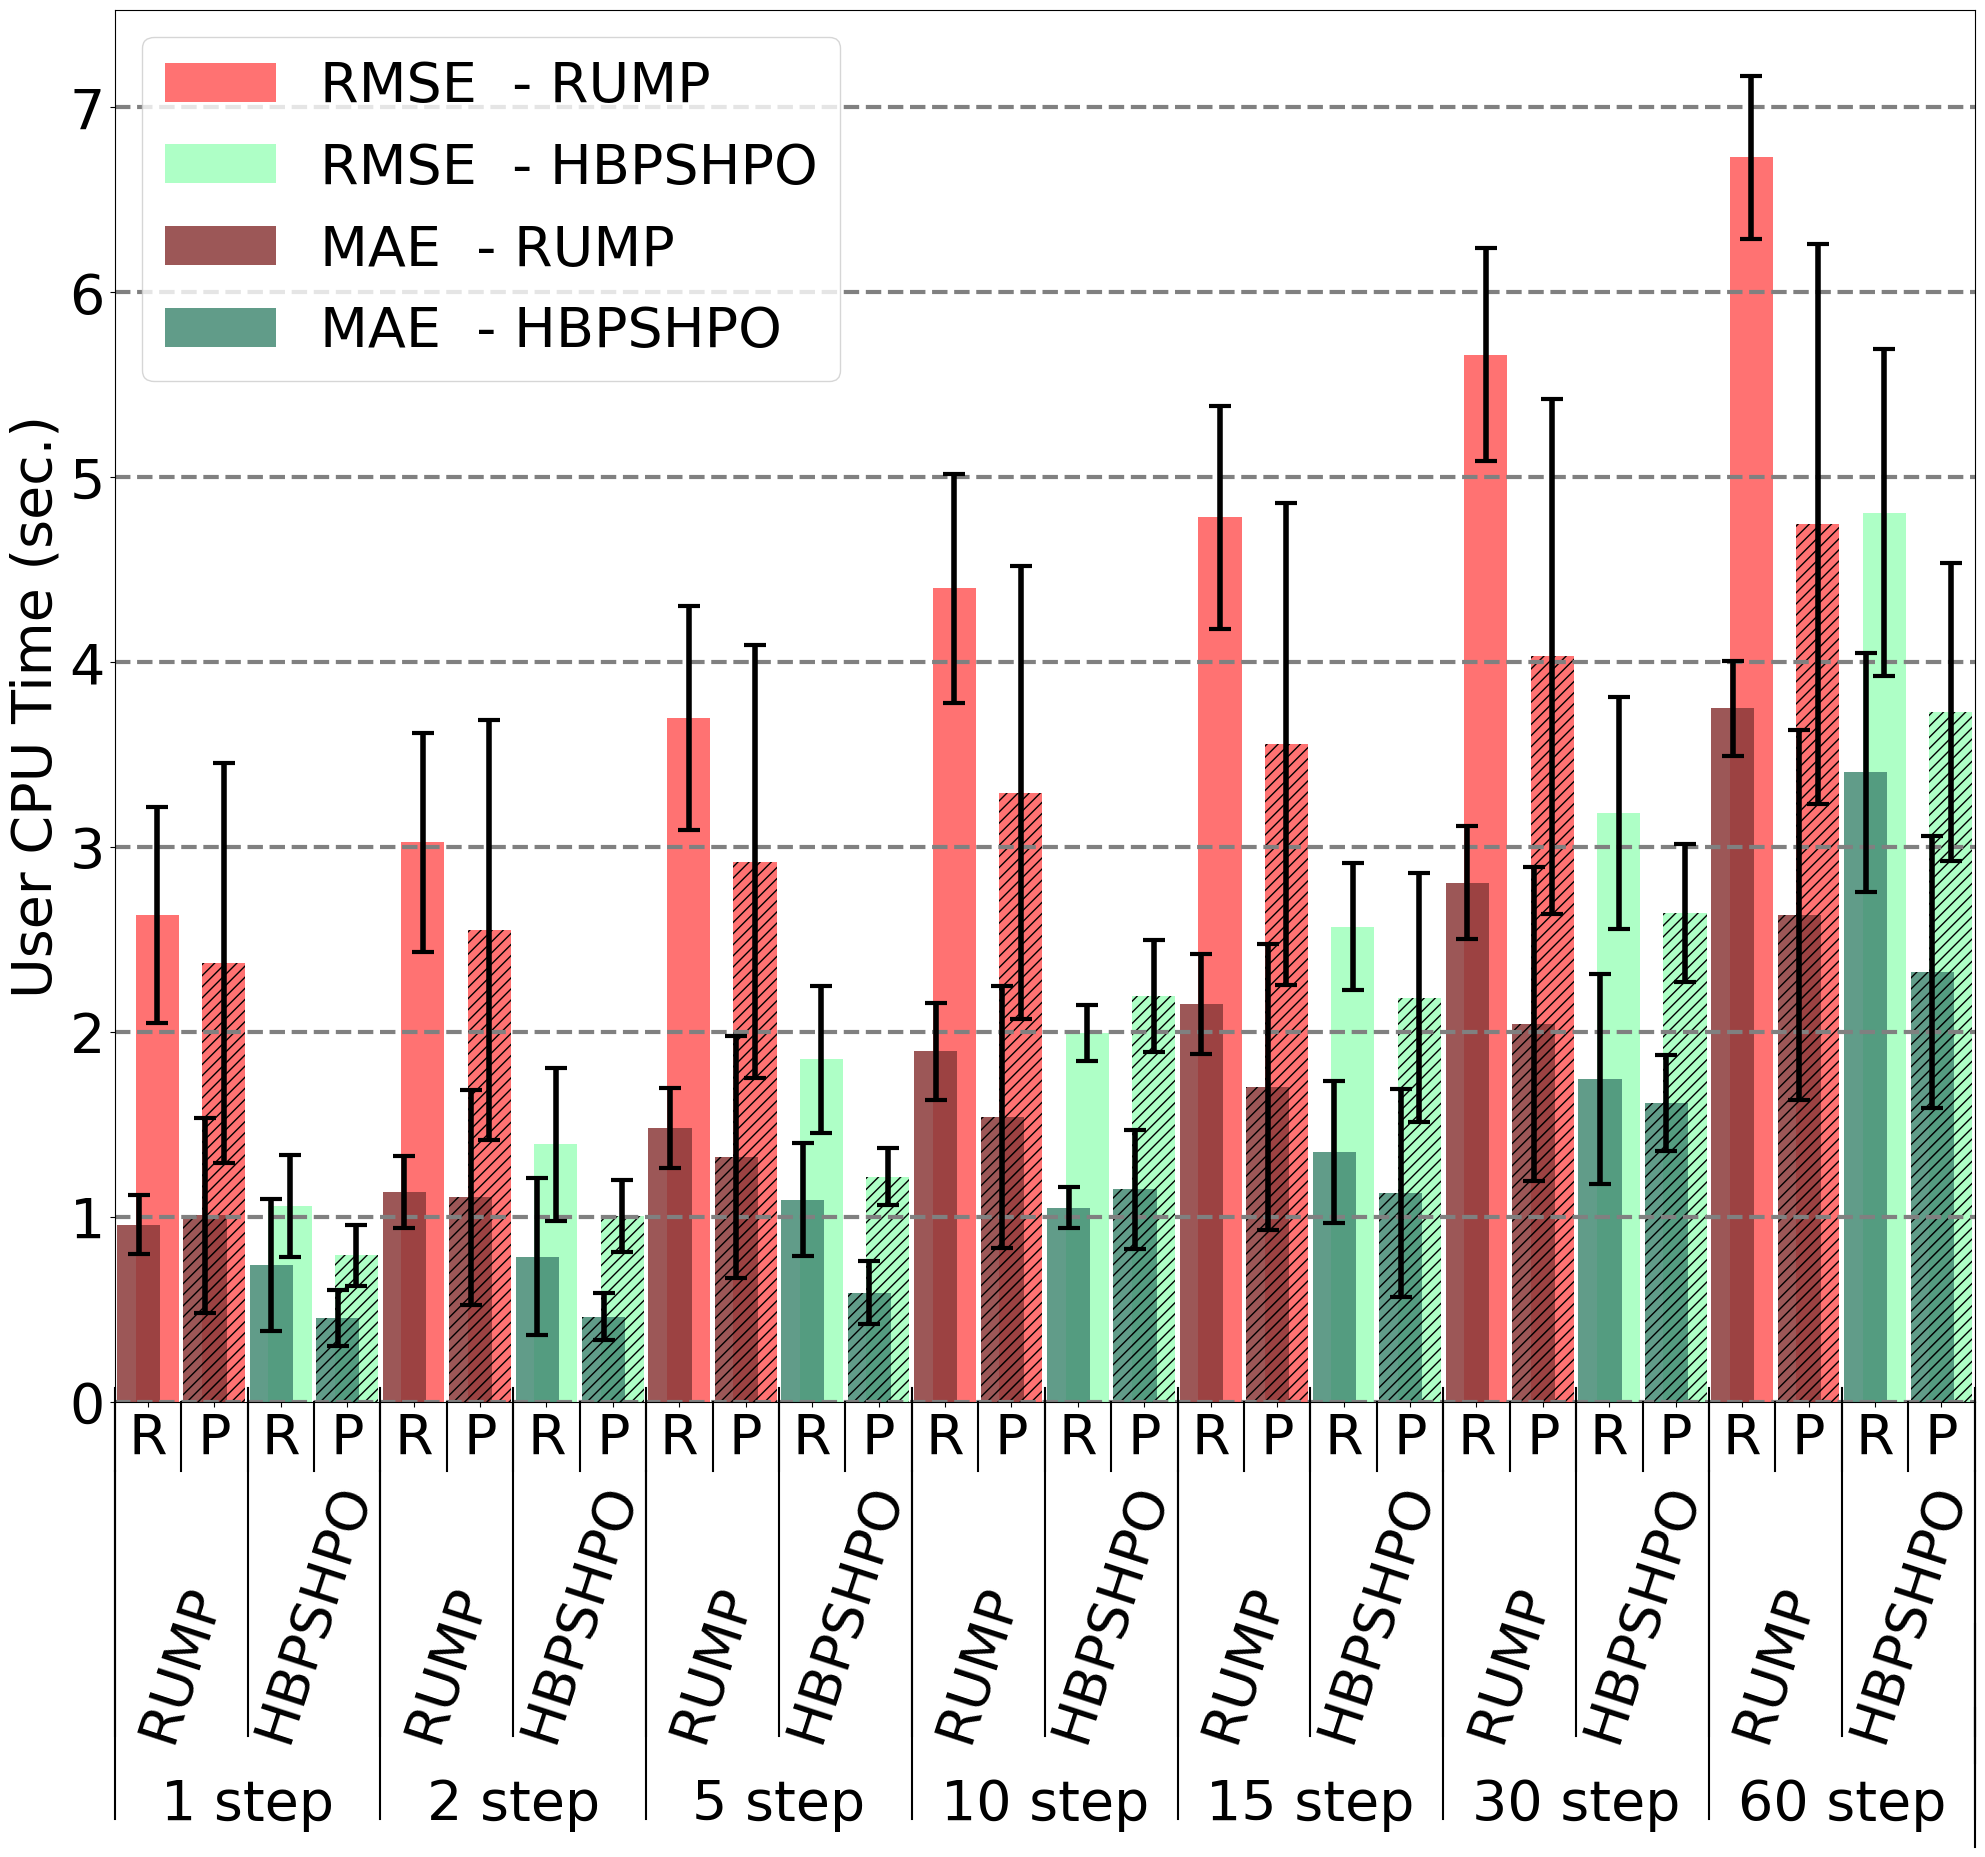

System CPU Time (sec.)


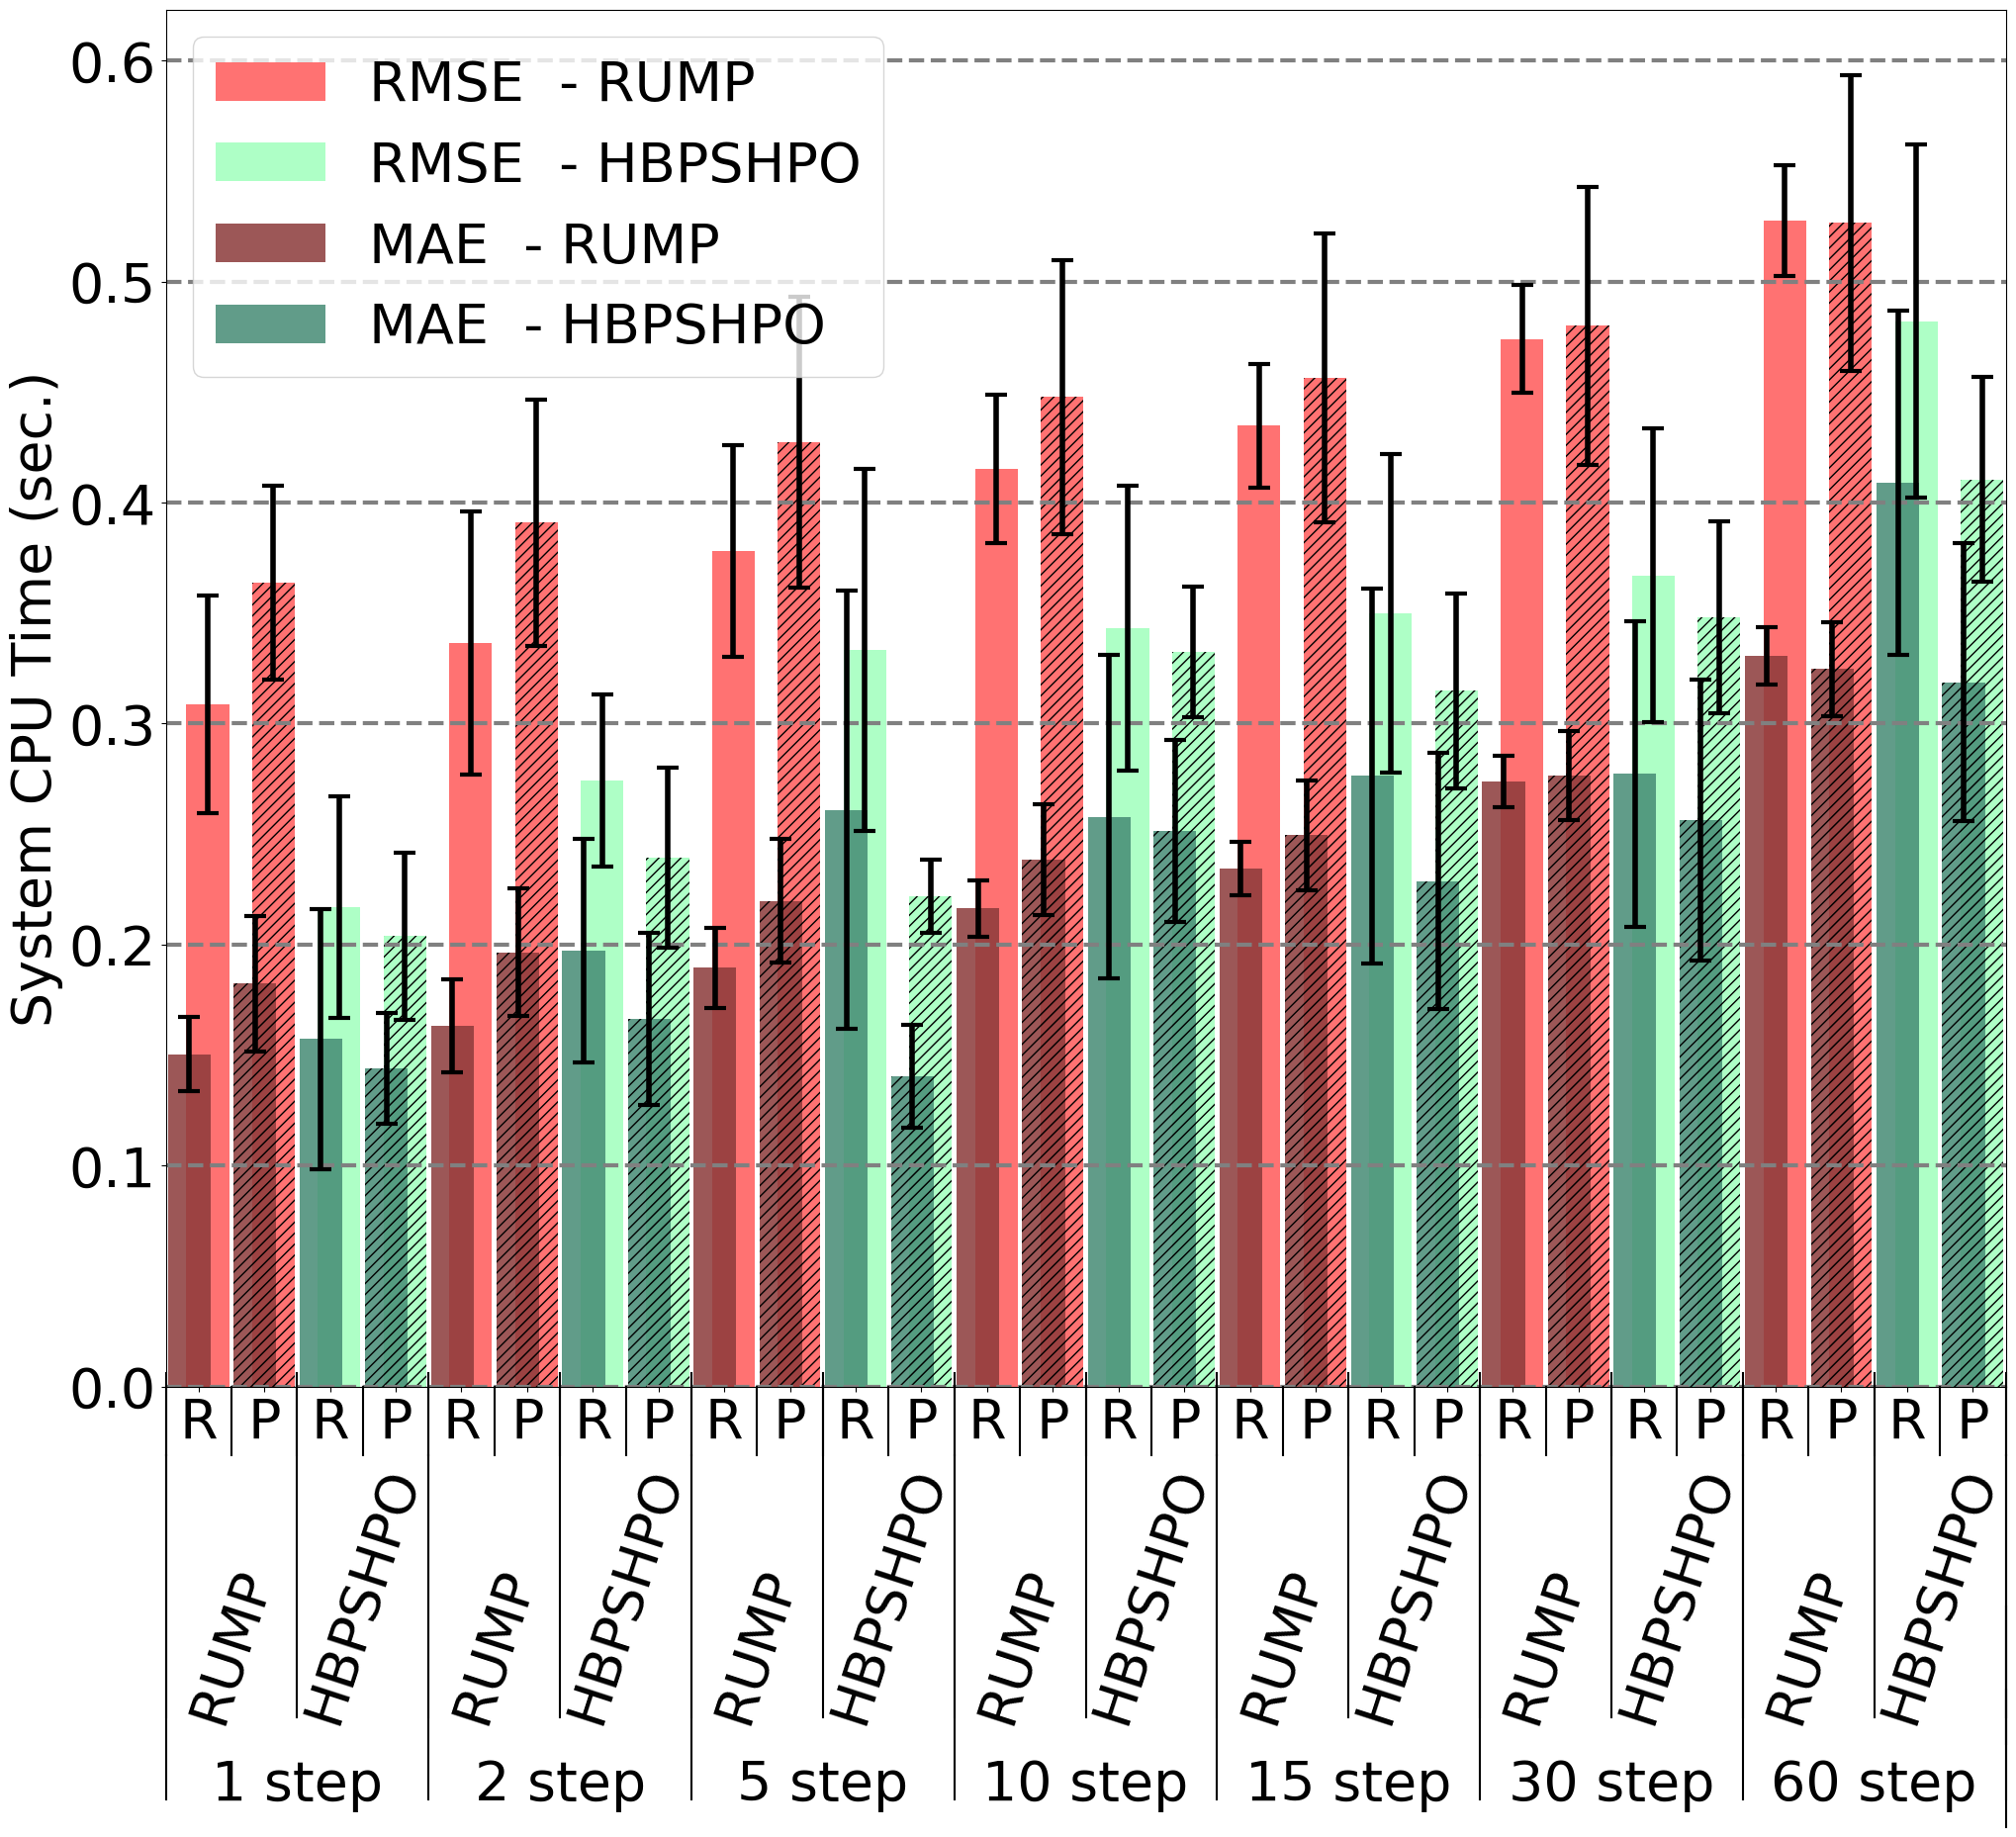

Idle CPU Time (sec.)


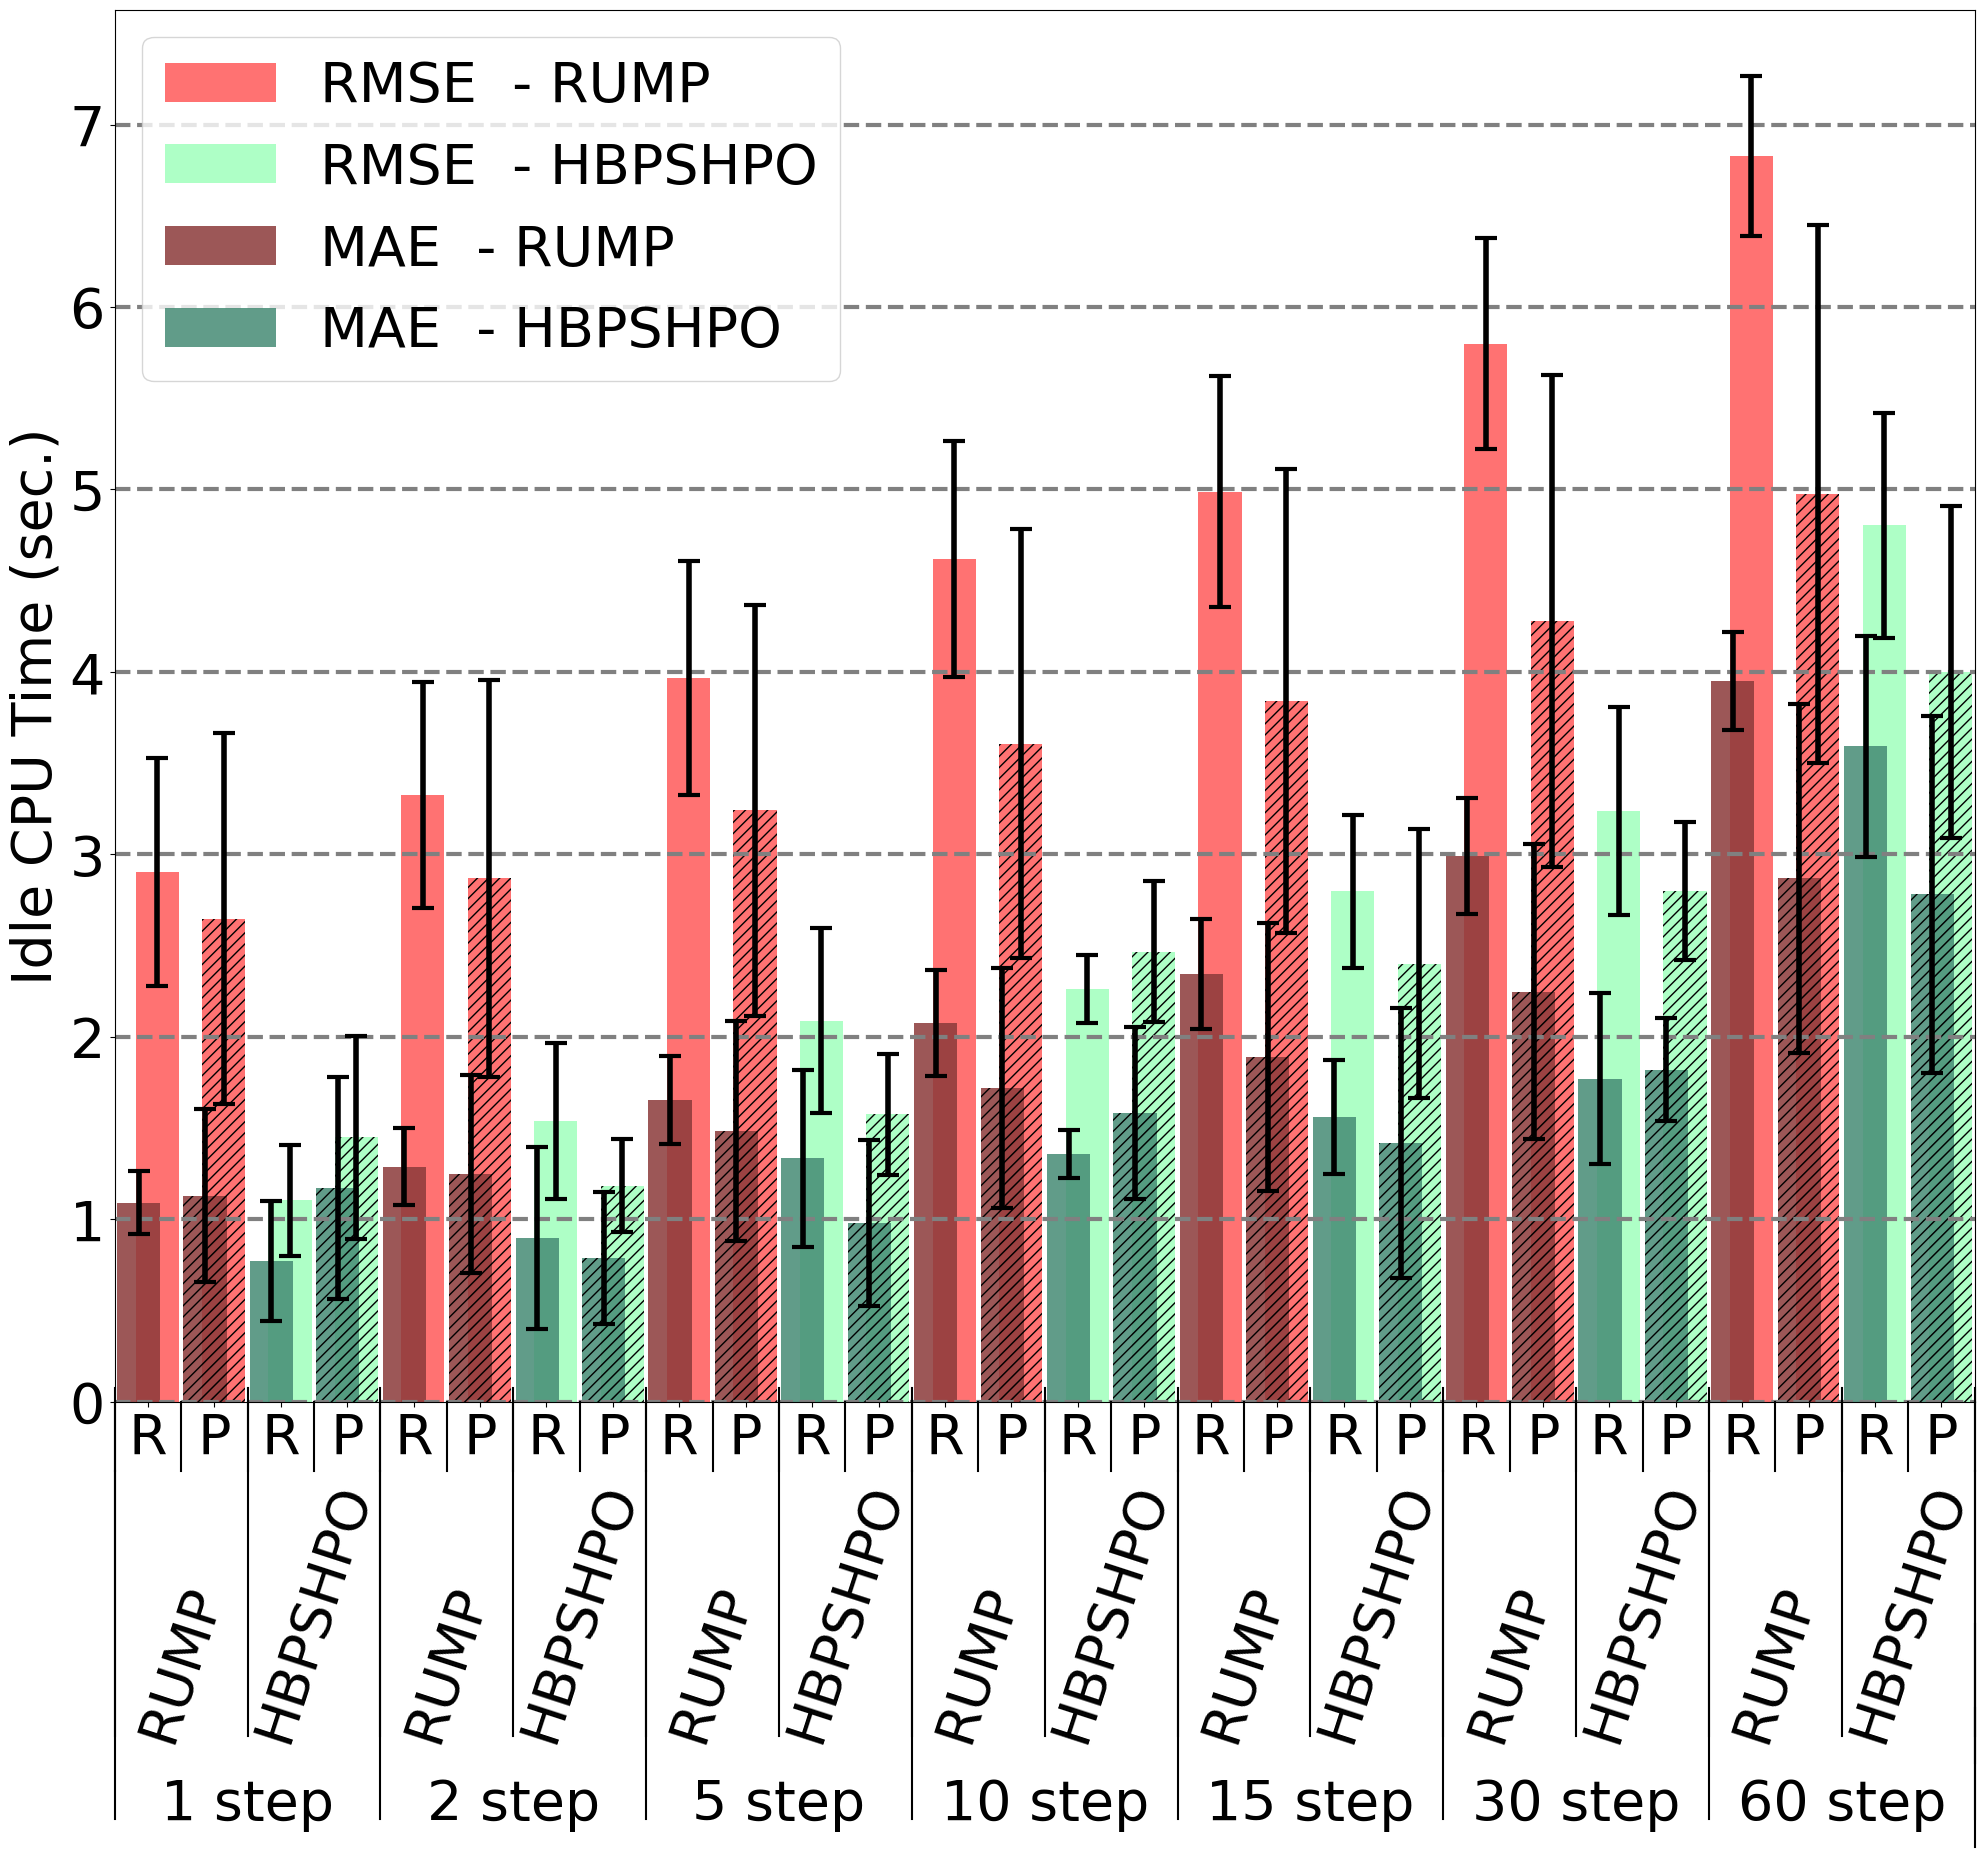

Memory Percent Usage


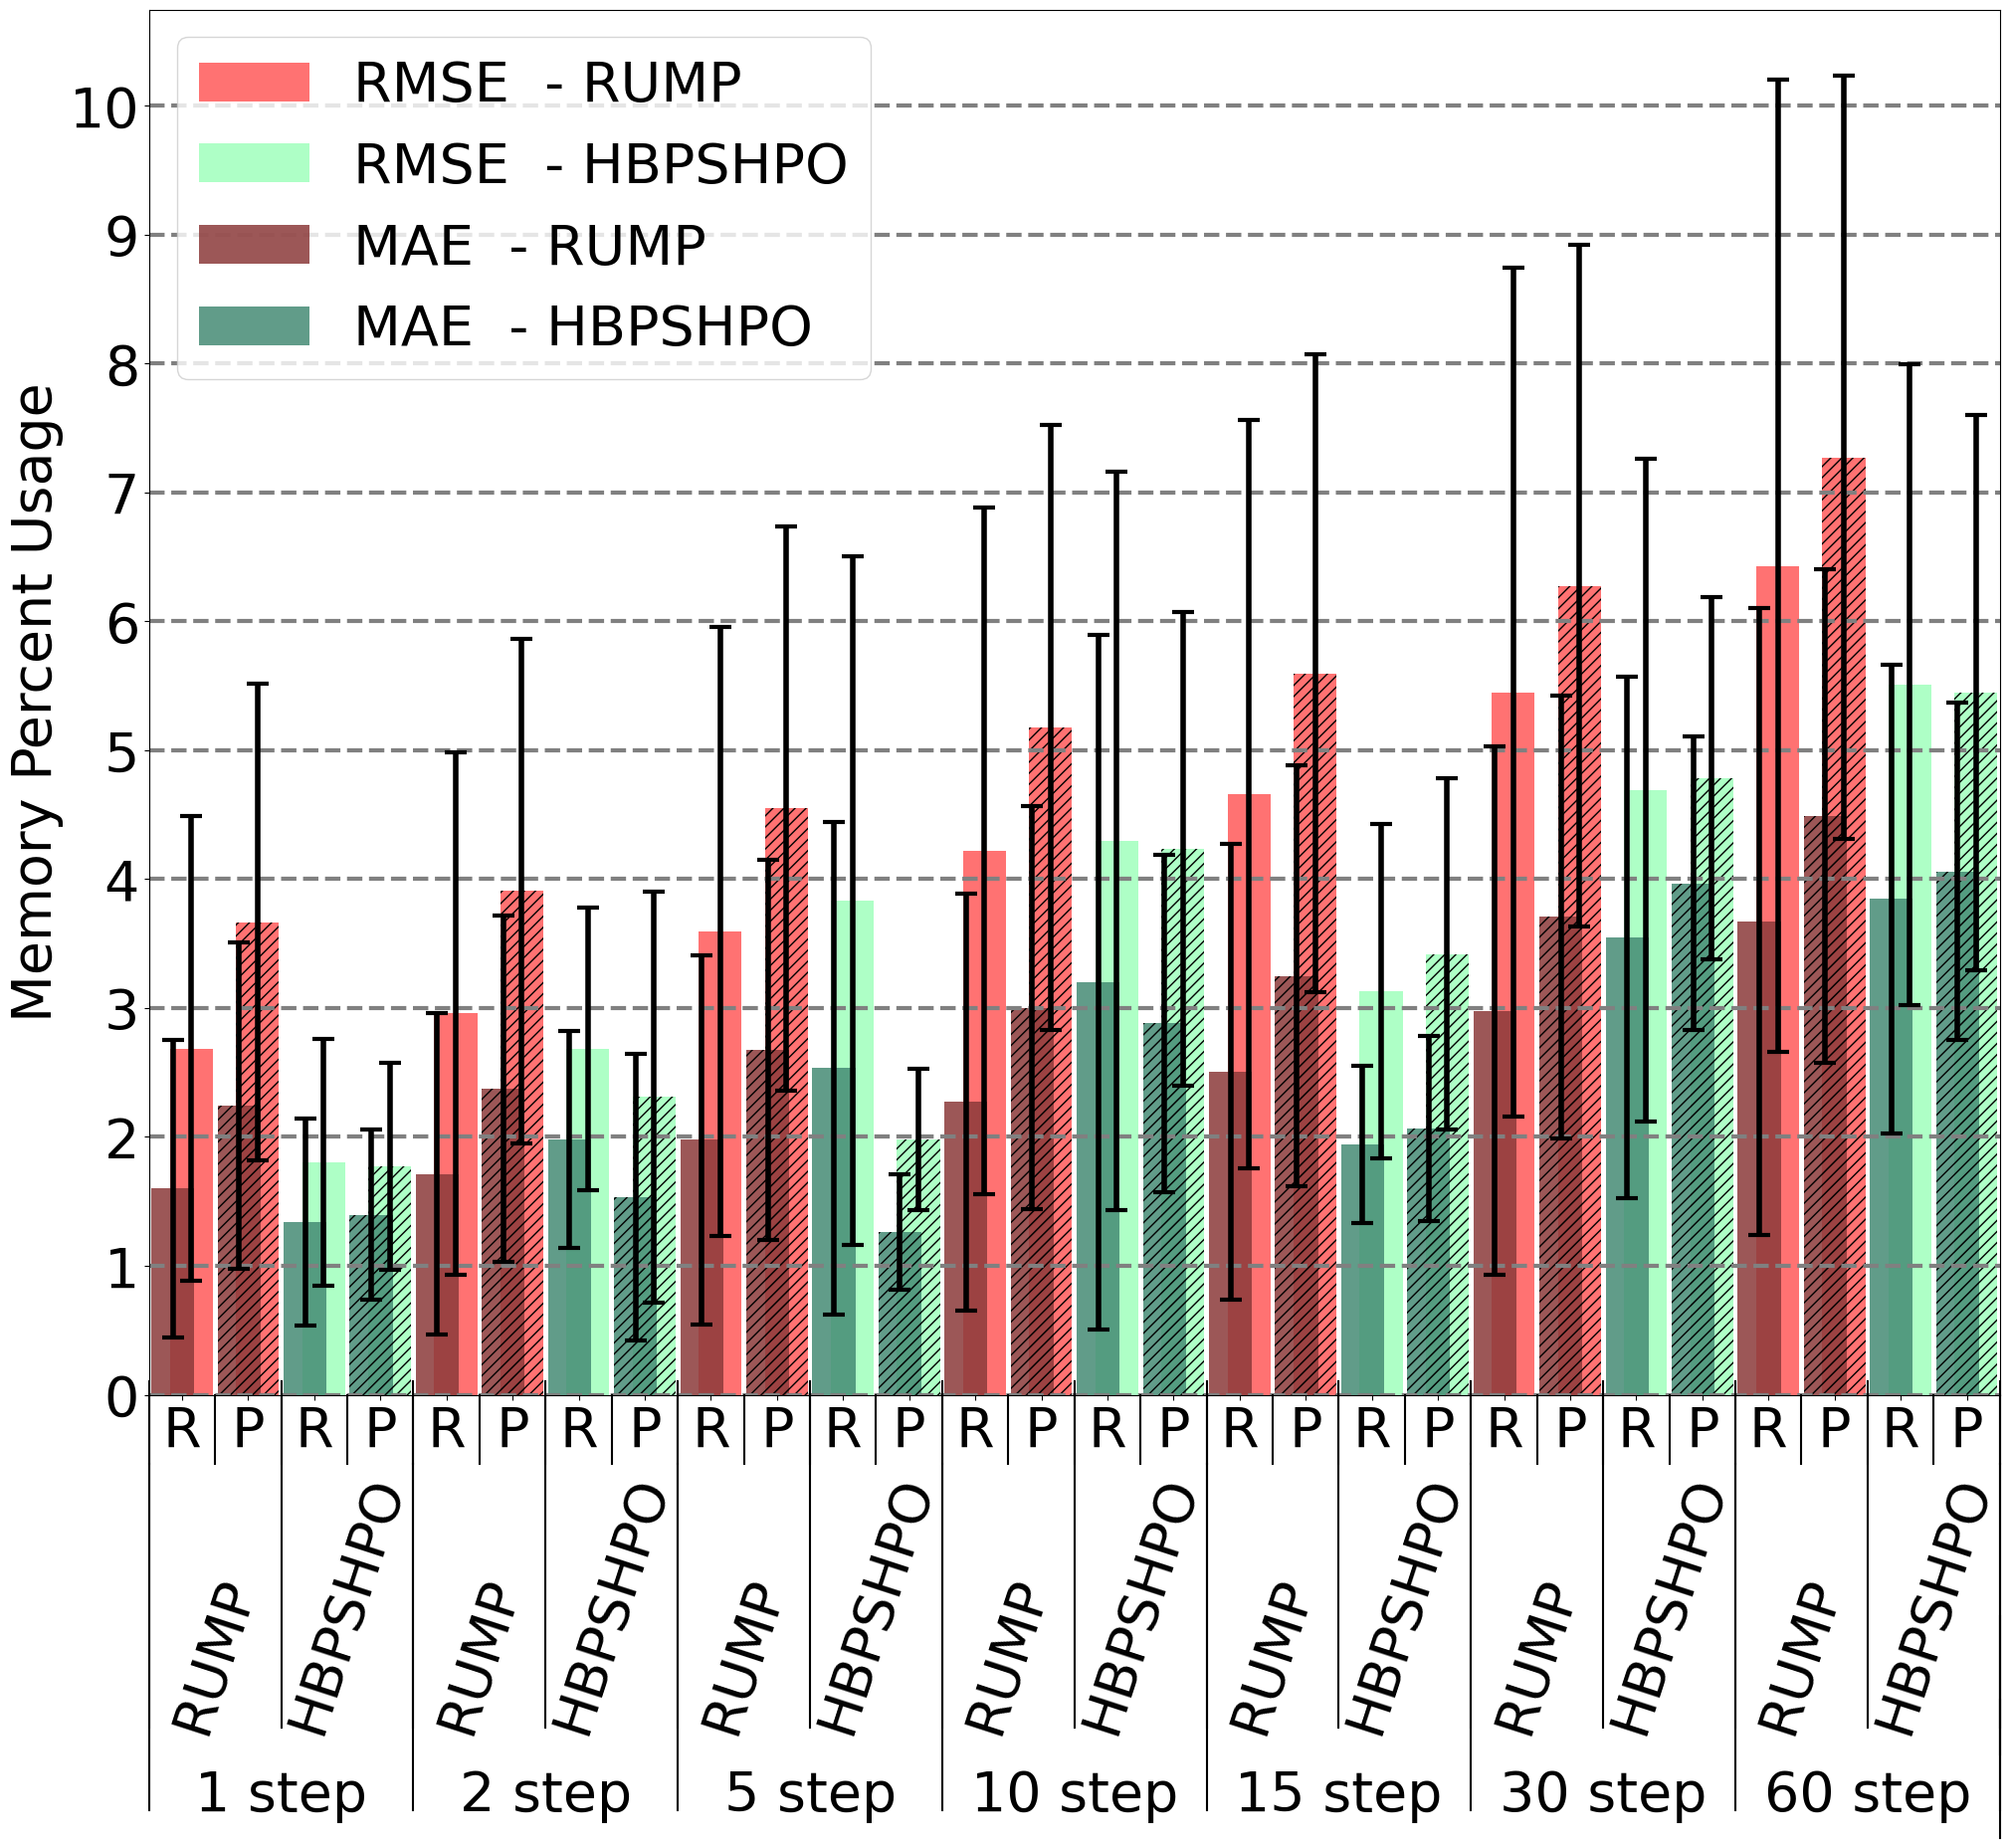

In [6]:
"""Get error figures"""
rpi_name = 'RPi4B2GB1_1200' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
rpi_name_list = ['RPi4B8GB_1800', 'RPi4B4GB_1500', 'RPi4B2GB2_1500', 'RPi4B2GB1_1200']
data_seq = 'random' # random, pattern
data_seq_list = ['random','pattern']
data_num = '' # _2, _3, _4

lookahead_list = [1,2,5,10,15,30,60]
HSMM_error_list, HBPSHPO_error_list = [], []


HSMM_columns = ['cpu_user_time_diff_mae','cpu_user_time_diff_rmse','cpu_system_time_diff_mae','cpu_system_time_diff_rmse','cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse','memory_mae','memory_rmse']
HBPSHPO_columns = ['User CPU mae','User CPU rmse','System CPU mae','System CPU rmse','Idle CPU mae','Idle CPU rmse','RAM mae','RAM rmse']
Resources = {'User CPU Time (sec.)':['cpu_user_time_diff_mae','cpu_user_time_diff_rmse','User CPU mae','User CPU rmse'],
             'System CPU Time (sec.)':['cpu_system_time_diff_mae','cpu_system_time_diff_rmse','System CPU mae','System CPU rmse'],
             'Idle CPU Time (sec.)':['cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse', 'Idle CPU mae','Idle CPU rmse'],
             'Memory Percent Usage':['memory_mae','memory_rmse','RAM mae','RAM rmse']}

mae_data_dict_full, rmse_data_dict_full = {}, {}

for res in Resources:
  mae_data_dict, rmse_data_dict = {}, {}
  

  for lookahead in lookahead_list:

    mae_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]}}
    rmse_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]}}

    for rpi_name in rpi_name_list:

      for data_seq in data_seq_list:

        

        #print(f"Error figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")

        model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'

        HSMM_temp = pd.read_csv(f"Results/{rpi_name.split('_')[0]}/HSMM_Error_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
        HBPSHPO_temp = pd.read_csv(f"Results/{rpi_name.split('_')[0]}/HBPSHPO_Error_Results_{model_name}.csv")

        if data_seq == 'random':
          data_seq = 'R'
        elif data_seq == 'pattern':
          data_seq = 'P'

        mae_data_dict[f"{lookahead} step"]['RUMP'][data_seq].append(HSMM_temp[Resources[res][0]][0])
        mae_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].append(HBPSHPO_temp[Resources[res][2]][0])
        rmse_data_dict[f"{lookahead} step"]['RUMP'][data_seq].append(HSMM_temp[Resources[res][1]][0])
        rmse_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].append(HBPSHPO_temp[Resources[res][3]][0])


      #mae_data_dict[f"{lookahead} step"]['HDP-HSMM'] = {k:float(sum(v))/len(v) for k, v in mae_data_dict[f"{lookahead} step"]['HDP-HSMM'].items()}
      #mae_data_dict[f"{lookahead} step"]['HBPSHPO'] = {k:float(sum(v))/len(v) for k, v in mae_data_dict[f"{lookahead} step"]['HBPSHPO'].items()}
      #rmse_data_dict[f"{lookahead} step"]['HDP-HSMM'] = {k:float(sum(v))/len(v) for k, v in rmse_data_dict[f"{lookahead} step"]['HDP-HSMM'].items()}
      #rmse_data_dict[f"{lookahead} step"]['HBPSHPO'] = {k:float(sum(v))/len(v) for k, v in rmse_data_dict[f"{lookahead} step"]['HBPSHPO'].items()}

  plt.rcParams.update({'font.size': 40})  
  fig = plt.figure(figsize=(24,24))
  ax = fig.add_subplot(1,1,1)
  print(res)
  ax.set_ylabel(res)
  label_group_bar(ax, mae_data_dict, rmse_data_dict)
  plt.legend(loc='best')
  plt.grid(lw=3,ls='--', c='grey', axis='y')
  fig.subplots_adjust(bottom=0.3)
  
  if res == 'User CPU Time (sec.)':
    plt.yticks(np.arange(0, 8, 1))
  elif res == 'System CPU Time (sec.)':
    plt.yticks(np.arange(0, 0.7, 0.1))
  elif res == 'Idle CPU Time (sec.)':
    plt.yticks(np.arange(0, 8, 1))
  elif res == 'Memory Percent Usage':
    plt.yticks(np.arange(0, 11, 1))
  fig.savefig(r"figures/{} Error Plot.png".format(res))
  plt.show()

  mae_data_dict_full[res] = mae_data_dict
  rmse_data_dict_full[res] = rmse_data_dict

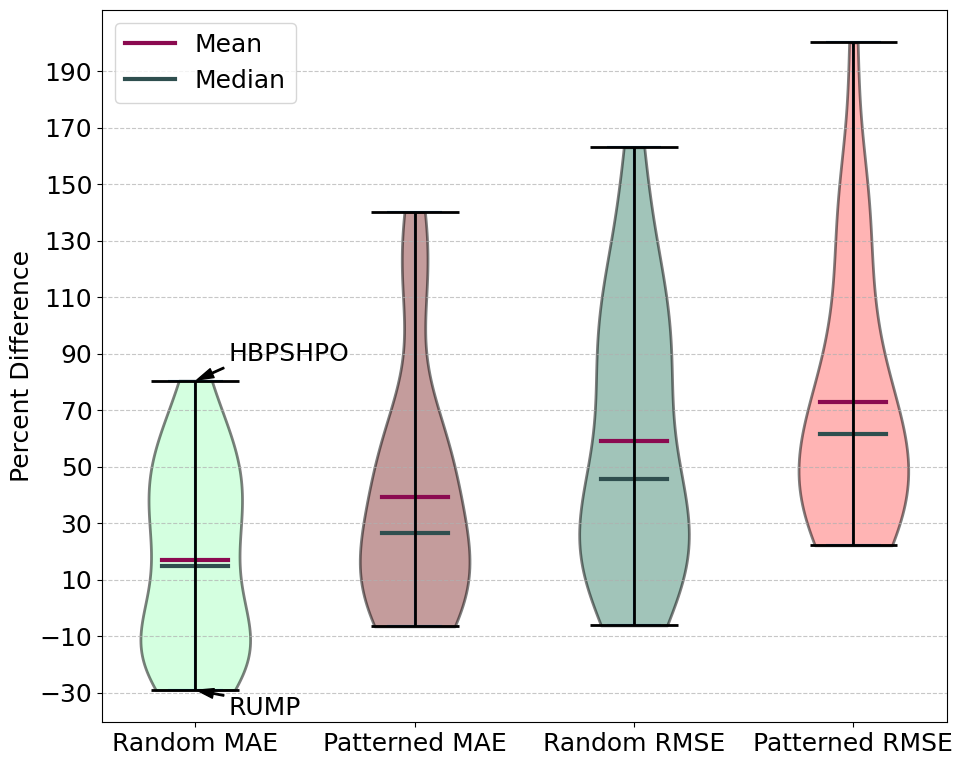

In [8]:
#Violin Plot
r_mae_percent, r_rmse_percent, p_mae_percent, p_rmse_percent = [], [], [], []
for (res1, mae_data), (res2, rmse_data) in zip(mae_data_dict_full.items(), rmse_data_dict_full.items()):
    for lookahead in lookahead_list:
        for data_type in ['R', 'P']:
            if data_type == 'R':
                r_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                r_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
            elif data_type == 'P':
                p_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                p_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

violin_plot_data = [r_mae_percent, p_mae_percent, r_rmse_percent, p_rmse_percent]
violin_plot_colors = ['#aaffc3', '#8B3A3A', '#458B74', '#FF6A6A']

vp = ax.violinplot(violin_plot_data)

for i, body in enumerate(vp['bodies']):
    body.set_facecolor(violin_plot_colors[i])
    body.set_edgecolor('black')
    body.set_linewidth(2)
    body.set_alpha(0.5)
    #change 

# Add mean and median lines
for i, data in enumerate(violin_plot_data):
    x = i + 1
    mean = np.mean(data)
    median = np.median(data)
    ax.plot([x - 0.15, x + 0.15], [mean, mean], color='#8B0A50', linestyle='-', linewidth=3)
    ax.plot([x - 0.15, x + 0.15], [median, median], color='#2F4F4F', linestyle='-', linewidth=3)

# Customize quartile lines
for i in range(len(violin_plot_data)):
    quartiles = np.percentile(violin_plot_data[i], [0.001, 99.999])
    ax.vlines(i + 1, quartiles[0], quartiles[1], color='black', linewidth=2)
    ax.hlines(quartiles, i + 1 - 0.2, i + 1 + 0.2, color='black', linewidth=2)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Random MAE', 'Patterned MAE', 'Random RMSE', 'Patterned RMSE'])
plt.ylabel('Percent Difference')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(np.arange(-30, 200, 20))

# Add annotations for the first violin chart
hbposhpo_annotation = 'HBPSHPO'
rump_annotation = 'RUMP'
first_violin_max = np.max(r_mae_percent)
first_violin_min = np.min(r_mae_percent)

ax.annotate(hbposhpo_annotation, xy=(1, first_violin_max), xytext=(1.15, first_violin_max + 7),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)

ax.annotate(rump_annotation, xy=(1, first_violin_min), xytext=(1.15, first_violin_min - 9),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)


# Add legend for median and mean lines
mean_line = plt.Line2D([], [], color='#8B0A50', linestyle='-', linewidth=3, label='Mean')
median_line = plt.Line2D([], [], color='#2F4F4F', linestyle='-', linewidth=3, label='Median')
plt.legend(handles=[mean_line, median_line], loc='upper left', fontsize=18)



plt.show()

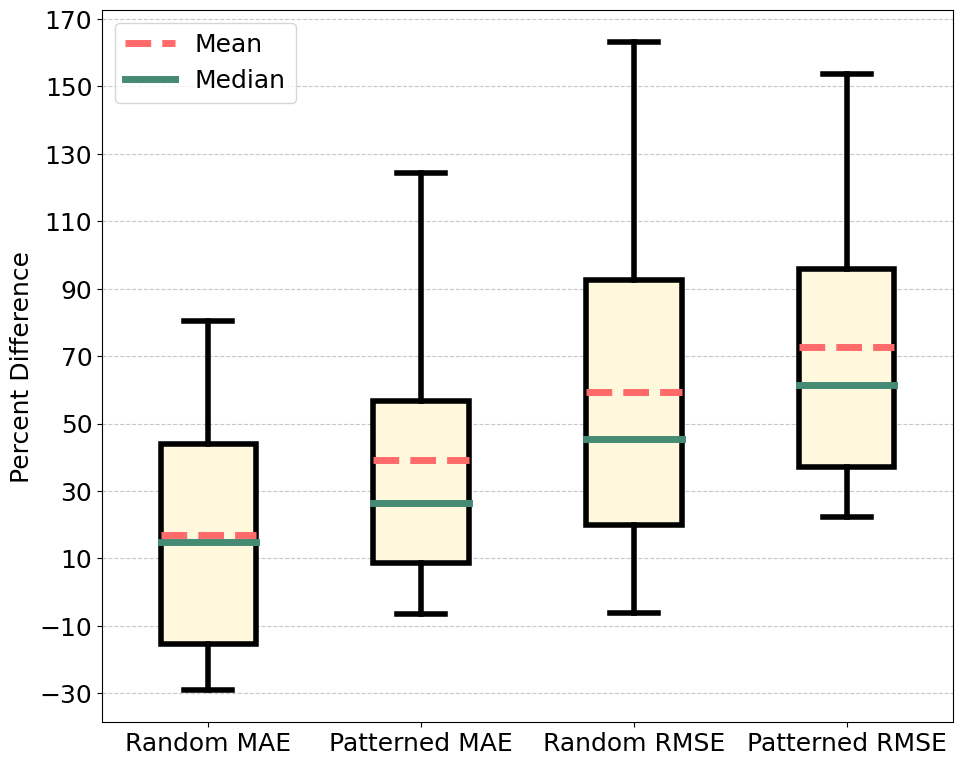

In [9]:
r_mae_percent, r_rmse_percent, p_mae_percent, p_rmse_percent = [], [], [], []
for (res1, mae_data), (res2, rmse_data) in zip(mae_data_dict_full.items(), rmse_data_dict_full.items()):
    for lookahead in lookahead_list:
        for data_type in ['R', 'P']:
            if data_type == 'R':
                r_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                r_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
            elif data_type == 'P':
                p_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                p_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

boxprops = dict(linewidth=4)
medianprops = dict(linewidth=5, color='#458B74')
meanlineprops = dict(linewidth=5, color='#FF6A6A')
whiskerprops = dict(linewidth=4)
capprops = dict(linewidth=4)

box_plot_data = [r_mae_percent, p_mae_percent, r_rmse_percent, p_rmse_percent]
box_plot_colors = ['#aaffc3', '#8B3A3A', '#458B74', '#FF6A6A']

bp = plt.boxplot(box_plot_data, showmeans=True, showfliers=False, meanline=True, patch_artist=True,
                 medianprops=medianprops, meanprops=meanlineprops, boxprops=boxprops, whiskerprops=whiskerprops,
                 capprops=capprops)

for patch, color in zip(bp['boxes'], box_plot_colors):
    patch.set_facecolor("#FFF8DC")

ax.set_xticklabels(['Random MAE', 'Patterned MAE', 'Random RMSE', 'Patterned RMSE'])
plt.ylabel('Percent Difference')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(np.arange(-30, 175, 20))


# Add legend for median and mean lines
mean_line = plt.Line2D([], [], color='#FF6A6A', linestyle='--', linewidth=5, label='Mean')
median_line = plt.Line2D([], [], color='#458B74', linestyle='-', linewidth=5, label='Median')
plt.legend(handles=[mean_line, median_line], loc='upper left', fontsize=18)

plt.show()